In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer

## Parameters

In [2]:
nr_particles = 10**0
nr_steps = 1*10**3
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1.0 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]
observer_substeps = np.array([True, True, True]) #np.array([True, True, True])
mean_free_path = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12])  # [m]
observer_spheres = np.array([-1.0]) # np.array([1.0*10**16, 1.0*10**17, 1.0*10**18, 1.0*10**19, 1.0*10**20]) # np.array([-1.0]) is just a time evolution observer

## Simulation setup

In [3]:
sim = Simulation()

source = Source(gyro_radius, mean_free_path, source_pos, nr_particles)
sim.add_source(source)

observer = Observer(observer_substeps)
sim.add_observer(observer)

%time sim.run_simulation(nr_steps)
sim.save_data('data')

start simulation
source
observer
CPU times: user 1.3 s, sys: 9.03 ms, total: 1.31 s
Wall time: 1.3 s


In [86]:
class Vizualizer():
    def __init__(self, df):
        print('init vizualizer')
        self.df = df
        
    def get_particle_ids(self):
        return list(map(int, (set(self.df['id']))))
        
    def plot_trajectory(self, x, y, c, particle_ids, n, file_name):
        if isinstance(particle_ids, int):
            # create a list if only one id was passed to particle_ids
            particle_ids = [particle_ids]
        plt.figure(figsize=(4.5,4))
        for particle_id in particle_ids:
            # filter the pandas dataframe for data of the current particle_id
            df_ids = self.df[self.df['id'] == particle_id]
            plt.scatter(df_ids[x][:n], df_ids[y][:n], s = 4, c=df_ids[c][:n], cmap='viridis')
        # plot colorbar next to plot
        cbar = plt.colorbar()
        cbar.set_label(c + ' [m]')
        plt.tight_layout()
        plt.xlabel(x + ' [m]')
        plt.ylabel(y + ' [m]')
        plt.tight_layout()
        if file_name is not None:
            plt.savefig(file_name)
        plt.show()
        
    def plot_trjectory_substeps(self, substep_0, substep_1, particle_ids, n, file_name):
        if isinstance(particle_ids, int):
            # create a list if only one id was passed to particle_ids
            particle_ids = [particle_ids]
        for particle_id in particle_ids:
            # filter the pandas dataframe for data of the current particle_id
            df_ids = self.df[self.df['id'] == particle_id][:n]
            plt.figure(figsize=(4,4))
            df_substep_0 = df_ids[df_ids['step'] == substep_0]
            df_substep_1 = df_ids[df_ids['step'] == substep_1]
            if len(df_substep_0) == 0 or len(df_substep_1) == 0:
                print('Error: Data has no substeps. Please observe substeps in simulation. Afterwards you can visualize them.')
                return
            x_substep_0 = df_substep_0['x']
            y_substep_0 = df_substep_0['y']
            x_substep_1 = df_substep_1['x']
            y_substep_1 = df_substep_1['y']
            try:
                x_0_1 = np.vstack([x_substep_0[:],x_substep_1[:-1]])
                y_0_1 = np.vstack([y_substep_0[:],y_substep_1[:-1]])
                x_1_0 = np.vstack([x_substep_1[1:],x_substep_0[2:]])
                y_1_0 = np.vstack([y_substep_1[1:],y_substep_0[2:]])
            except:
                print('except')
                x_0_1 = np.vstack([x_substep_0[:],x_substep_1[:]])
                y_0_1 = np.vstack([y_substep_0[:],y_substep_1[:]])
                x_1_0 = np.vstack([x_substep_1[:-1],x_substep_0[1:]])
                y_1_0 = np.vstack([y_substep_1[:-1],y_substep_0[1:]])
            # legend for substeps
            plt.plot([x_substep_0.tolist()[0]], [y_substep_0.tolist()[0]], 'r', ls='--', label='move '+str(substep_0)+'➔'+str(substep_1))
            plt.plot([x_substep_1.tolist()[0]], [y_substep_1.tolist()[0]], 'b', ls=':', label='move '+str(substep_1)+'➔'+str(substep_0))
            plt.plot(x_0_1, y_0_1, 'r', ls='--')
            plt.plot(x_1_0, y_1_0, 'b', ls=':')
            plt.scatter(x_substep_0, y_substep_0, c='r', marker='^', s=15, label='after phi')
            plt.scatter(x_substep_1, y_substep_1, c='green', marker='d', s=15, label='after rho')
            
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.legend()
        plt.axis('square')
        plt.tight_layout()
        if file_name is not None:
            plt.savefig(file_name)
        plt.show()

init vizualizer
except


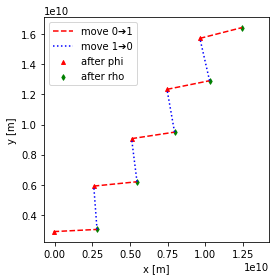

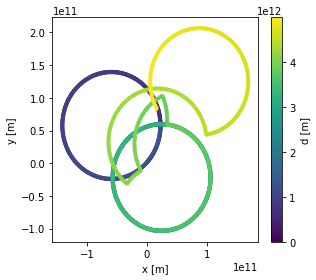

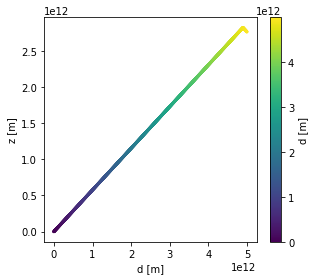

In [87]:
df = pd.read_pickle("data.pkl")

df_time_evolution_observer = df.loc[df['radius'] == -1.0]
vis = Vizualizer(df_time_evolution_observer)
particle_ids = vis.get_particle_ids()
vis.plot_trjectory_substeps(0, 1, particle_ids[0], 16, None)
vis.plot_trajectory('x', 'y', 'd', particle_ids[:], -1, None)
vis.plot_trajectory('d', 'z', 'd', particle_ids[:], -1, None)

In [8]:
df_ids = df[df['id'] == 0]
df_ids

,id,i,d,x,y,z,radius,step
0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.0,NaN
1,0.0,2.0,6.666666e+09,2.594650e+09,5.908776e+09,2.886751e+09,-1.0,0.0
2,0.0,2.0,8.333333e+09,5.466976e+09,6.197000e+09,2.886751e+09,-1.0,1.0
3,0.0,2.0,1.000000e+10,5.466976e+09,6.197000e+09,5.773502e+09,-1.0,2.0
4,0.0,10.0,4.666667e+10,1.789440e+10,3.405724e+10,2.598076e+10,-1.0,0.0
...,...,...,...,...,...,...,...,...
2996,0.0,9980.0,4.988852e+13,-4.407934e+11,-9.423448e+11,4.996934e+12,-1.0,1.0
2997,0.0,9980.0,4.989018e+13,-4.407934e+11,-9.423448e+11,4.999821e+12,-1.0,2.0
2998,0.0,9990.0,4.993681e+13,-4.433406e+11,-9.807323e+11,5.025802e+12,-1.0,0.0
2999,0.0,9990.0,4.993847e+13,-4.459794e+11,-9.819029e+11,5.025802e+12,-1.0,1.0
